PROBLEMA DE DIMENSIONAMENTO DE LOTES MULTIESTÁGIO

![Descrição da imagem](Definição3.png)


OBJETIVO: MINIMIZAR OS CUSTOS DE PRODUÇÃO DOS X(Xit) ITENS I PRODUZIDOS NO PERÍODO T, PARA ATENDER A DEMANDA (Dit) DEMANDA DO ITEM I PRODUZIDO NO PERÍODO T, LEVANDO OS CUSTO DE ESTOCAR O ITEM I NO PERÍODO T EM CONSIDERAÇÃO (Iit)


In [11]:
%pip install pulp
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, PULP_CBC_CMD

In [12]:
def ler_arquivo_multi(problema_multi):
    # Abre o arquivo e remove linhas em branco ou com apenas espaços
    with open(problema_multi, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip() != ""]
    idx = 0  # índice de leitura de linhas do arquivo (variável auxiliar)

    
    T, n, K = map(int, lines[idx].split()); idx += 1 # pega a linha de indice idx convertendo para inteiro e separando em 3 variáveis e retira os espaços
    # T = número de períodos
    # n = número de itens
    # K = número de recursos
    #passa para a próxima linha

    d = np.array([list(map(float, lines[idx + j].split())) for j in range(n)])
    idx += n # o idx pega o valor atual que no caso aqui seria 1 e soma com n, ou seja, pula n linhas para ler a próxima parte do arquivo
    # ----------------------------------------
     #O código guarda na variável d uma matriz
    #formada por listas de valores convertidos em ponto flutuante.
    #Ele lê essas listas a partir da linha indicada por idx,
    #e usa j (que vai de 0 até n-1) para alternar as linhas que serão lidas.
    #Cada linha representa a demanda de um item ao longo dos períodos.
    #O split() tira os espaços e separa os números da linha.

    #Assim, j é o índice das linhas (itens), e n é o número total de linhas (= número de itens

    c = np.array([list(map(float, lines[idx + j].split())) for j in range(n)])
    idx += n
    # Após a leitura da matriz de demanda, o código após pular as n linhas ele le as linhas relativas aos custos de produção.
    # Cada linha representa os custos de produção de um item ao longo dos períodos.
    # A estrutura é semelhante à leitura da matriz de demanda, onde j é o índice das linhas (itens), e n é o número total de linhas (= número de itens).
    # ----------------------------------------
    h = np.array([list(map(float, lines[idx + j].split())) for j in range(n)])
    idx += n
    # Após a leitura da matriz de custos, o código após pular as n linhas ele le as linhas relativas aos custos de produção.
    # Cada linha representa os custos de estocar  um item ao longo dos períodos.
    # A estrutura é semelhante à leitura da matriz de custos, onde j é o índice das linhas (itens), e n é o número total de linhas (= número de itens).
   
    B = np.array([list(map(float, lines[idx + j].split())) for j in range(n)])
    idx += n

    # Após a leitura da matriz de custo de estocar, o código após pular as n linhas ele le as linhas relativas aos custos de produção.
    # Cada linha representa os itens B usado para produzir outro item.
    # A estrutura é semelhante à leitura da matriz de de custos de estocar, onde j é o índice das linhas (itens), e n é o número total de linhas (= número de itens).


    Rcons = np.array([list(map(float, lines[idx + k].split())) for k in range(K)])
    idx += K
     
    #rki

    #Nesse caso ele lê as linhas relativas ao consumo de recursos e interage sobre k (que vai de 0 até K-1) 
    #para ler as linhas que representam o consumo de cada recurso ao longo dos períodos.
    # Cada linha representa o consumo de um recurso ao longo dos períodos.
    # A estrutura é semelhante à leitura das matrizes anteriores, onde k é o índice das
    # linhas (recursos), e K é o número total de linhas (= número de recursos). 
    # 
    # RESTRIÇÕES DE RECURSOS 

    Rcap = np.array([list(map(float, lines[idx + k].split())) for k in range(K)])
    idx += K
    #Rkt

    # Após a leitura da matriz de consumo de recursos, o código após pular as K linhas ele le as linhas relativas as capacidades dos recursos.
    # Cada linha representa a capacidade de um recurso ao longo dos períodos.
    # A estrutura é semelhante à leitura da matriz de consumo de recursos, onde k é o
    # índice das linhas (recursos), e K é o número total de linhas (= número de recursos).  
    # RESTRIÇÃO DE CAPACIDADE DE RECURSOS

 
    I0 = np.zeros(n) # vetor de zeros se não fornecido
    if idx < len(lines): #verifica se há mais linhas a serem lidas
        parts = lines[idx].split() #pega a linha atual que não foi lida e separa em partes
        if len(parts) == n: #verifica se o número de partes é igual ao número de itens ou seja se cada item tem um estoque inicial
            I0 = np.array(list(map(float, parts))) #converte as partes para float 
            idx += 1 #incrementa o índice para a próxima linha

    # Retorna todos os parâmetros do problema
    return T, n, K, d, c, h, B, Rcons, Rcap, I0

In [ ]:
def otimizar_multi(T, n, K, d, c, h, B, Rcons, Rcap, I0=None, use_integer=False):
    # Se nenhum estoque inicial for informado, assume zero
    if I0 is None:
        I0 = np.zeros(n)

    # Criação do problema de otimização (minimização)
    prob = LpProblem("Dimensionamento_Multiestagio", LpMinimize)

    # Dicionários para armazenar variáveis de decisão
    x = {}  # produção do item j no período t
    I = {}  # estoque do item j no final do período t

    for j in range(n):
        for t in range(1, T+1):
            name_x = f"x_{j+1}_{t}" # nomeia as variáveis de decisão de produção Xjt
            name_I = f"I_{j+1}_{t}" # nomeia as variáveis de decisão de estoque Ijt

            # Define tipo das variáveis (inteiras ou contínuas)
            if use_integer: #variáveis inteiras
                x[(j,t)] = LpVariable(name_x, lowBound=0, cat='Integer') 
                I[(j,t)] = LpVariable(name_I, lowBound=0, cat='Integer')
            else: #variáveis contínuas (decimais)
                x[(j,t)] = LpVariable(name_x, lowBound=0)
                I[(j,t)] = LpVariable(name_I, lowBound=0)


    prob += lpSum([c[j,t-1] * x[(j,t)] for j in range(n) for t in range(1, T+1)]) \
          + lpSum([h[j,t-1] * I[(j,t)] for j in range(n) for t in range(1, T+1)]) #soma dos custos de produção e estoque

    # --------------------------------------------------------
    # Restrições de Balanço de Estoque por item e período:
    #
    # x_{j,t} + I_{j,t-1} = d_{j,t} + Σ_i b_{j,i} * x_{i,t} + I_{j,t}
    #
    # Interpretação:
    # (produção + estoque anterior) deve atender
    # (demanda + consumo interno + estoque final)
    # --------------------------------------------------------
    for j in range(n):
        for t in range(1, T+1):
            # Estoque do período anterior (ou inicial no t=1) I 0 É O ESTOQUE INICIAL SE NÃO É O VALOR QUE ESTA NA VARIAVEL DO ESTOQUE
            prev_I = I0[j] if t == 1 else I[(j, t-1)]

            # Consumo interno do item j para produção de outros itens SOMA DOS ITENS USADOS PARA PRODUZIR O ITEM J
            consumo_interno = lpSum([B[j, i] * x[(i, t)] for i in range(n)])

            # Balanço de material
            prob += x[(j,t)] + prev_I - I[(j,t)] == d[j, t-1] + consumo_interno, \
                    f"balanco_item{j+1}_t{t}"


    
    # Σ_j r_{k,j} * x_{j,t} ≤ R_{k,t}
    
    for k in range(K): #A soma do consumo de todos os produtos que usam o recurso k não pode ultrapassar a capacidade máxima desse recurso no período
        for t in range(1, T+1): 
            prob += lpSum([Rcons[k, j] * x[(j, t)] for j in range(n)]) <= Rcap[k, t-1], \
                    f"recurso_{k+1}_t{t}"

    # --------------------------------------------------------
    # Resolução do modelo com o solver CBC
    # --------------------------------------------------------
    prob.solve(PULP_CBC_CMD(msg=1))  # msg=1 exibe o log de solução

    # --------------------------------------------------------
    # Coleta dos resultados (valores das variáveis)
    # --------------------------------------------------------
    x_sol = np.zeros((n, T))
    I_sol = np.zeros((n, T))

    for j in range(n):
        for t in range(1, T+1): #PEGA O VALOR OTIMO DE CADA VARIAVEL
            valx = x[(j,t)].varValue  # valor ótimo de x_{j,t} P
            vali = I[(j,t)].varValue  # valor ótimo de I_{j,t}
            x_sol[j, t-1] = 0.0 if valx is None else float(valx)
            I_sol[j, t-1] = 0.0 if vali is None else float(vali)

    # Cálculo do custo total ótimo FUNÇÃO OBJETIVO
    obj = sum(c[j,t] * x_sol[j,t] for j in range(n) for t in range(T)) + \
          sum(h[j,t] * I_sol[j,t] for j in range(n) for t in range(T))
    
    # Retorna solução ótima
    return x_sol, I_sol, obj



NameError: name 'prob' is not defined

In [14]:
if __name__ == "__main__":
    # Leitura dos dados do arquivo de entrada
    T, n, K, d, c, h, B, Rcons, Rcap, I0 = ler_arquivo_multi("problema_multi.txt")

    # Chamada da função de otimização
    x_sol, I_sol, obj = otimizar_multi(T, n, K, d, c, h, B, Rcons, Rcap, I0, use_integer=False)

    # Impressão dos resultados
    print("x_sol (produção por item e período):\n", x_sol)
    print("I_sol (estoque por item e período):\n", I_sol)
    print("Custo total: ", obj)

x_sol (produção por item e período):
 [[63.846154 16.153846 30.      ]
 [12.769231 39.230769 30.      ]]
I_sol (estoque por item e período):
 [[23.846154  0.        0.      ]
 [ 0.       16.        0.      ]]
Custo total:  694.8461540000001


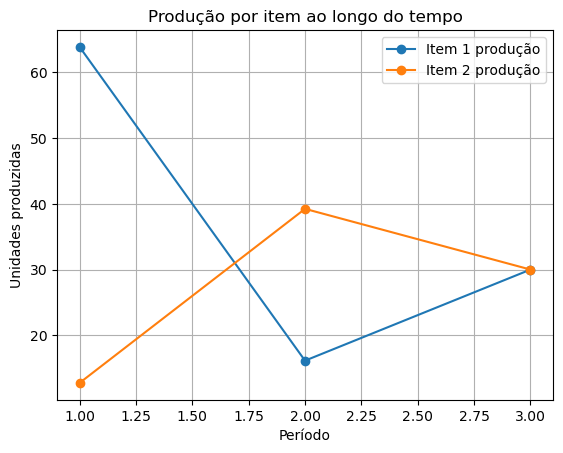

In [15]:
for j in range(n):
    plt.plot(range(1, T+1), x_sol[j, :], marker='o', label=f'Item {j+1} produção')
plt.xlabel('Período')
plt.ylabel('Unidades produzidas')
plt.title('Produção por item ao longo do tempo')
plt.legend()
plt.grid(True)
plt.show()